# I. Introdução

![Simulated Annealing](SA_animation.gif)
Como a gente viu em aula, simulated annealing é uma técnica probabilistica usada para achar uma solução aproximada.  Vamos então implementar o SA para o problema do [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem) usando as capitais dos EUA. 

Fonte a imagem: [Simulated Annealing - By Kingpin13 (Own work) [CC0], via Wikimedia Commons (Attribution not required)](https://commons.wikimedia.org/wiki/File:Hill_Climbing_with_Simulated_Annealing.gif)

## Ideia geral

  0. Implementar o loop principal do `simulated_annealing()` 
  0. Implementar  uma classe  `TravelingSalesman` com metodos  sucessores()  e valor() 
  0. Bolar uma função  esquema() pra definir um esquema de temperatura do algoritmo


In [55]:
import json
import copy

import numpy as np
import numpy.random as random  
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [56]:
"""pega entrada e define umas funções para visualizacao."""

# Tem este mapa em  http://www.usgs.gov/visual-id/credit_usgs.html 
mapa = mpimg.imread("map.png")  # mapa dos eua

# Lista das capitais com as coordenadas no mapa
with open('capitals.json', 'r') as capitais_file:
    capitais = json.load(capitais_file)
capitais_list = list(capitais.items())

def mostra_caminho(caminho, cidade_inicial, w=12, h=8):
    """Plota caminho."""
    x, y = list(zip(*caminho))
    _, (x0, y0) = cidade_inicial
    plt.imshow(mapa)
    plt.plot(x0, y0, 'y*', markersize=15)  # uma estrela amarela na cidade inicial
    plt.plot(x + x[:1], y + y[:1])  # por a cidade inicial no fim do caminho 
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])

In [57]:
capitais_list

[('Oklahoma City', [392.8, 356.4]),
 ('Montgomery', [559.6, 404.8]),
 ('Saint Paul', [451.6, 186.0]),
 ('Trenton', [698.8, 239.6]),
 ('Salt Lake City', [204.0, 243.2]),
 ('Columbus', [590.8, 263.2]),
 ('Austin', [389.2, 448.4]),
 ('Phoenix', [179.6, 371.2]),
 ('Hartford', [719.6, 205.2]),
 ('Baton Rouge', [489.6, 442.0]),
 ('Salem', [80.0, 139.2]),
 ('Little Rock', [469.2, 367.2]),
 ('Richmond', [673.2, 293.6]),
 ('Jackson', [501.6, 409.6]),
 ('Des Moines', [447.6, 246.0]),
 ('Lansing', [563.6, 216.4]),
 ('Denver', [293.6, 274.0]),
 ('Boise', [159.6, 182.8]),
 ('Raleigh', [662.0, 328.8]),
 ('Atlanta', [585.6, 376.8]),
 ('Madison', [500.8, 217.6]),
 ('Indianapolis', [548.0, 272.8]),
 ('Nashville', [546.4, 336.8]),
 ('Columbia', [632.4, 364.8]),
 ('Providence', [735.2, 201.2]),
 ('Boston', [738.4, 190.8]),
 ('Tallahassee', [594.8, 434.8]),
 ('Sacramento', [68.4, 254.0]),
 ('Albany', [702.0, 193.6]),
 ('Harrisburg', [670.8, 244.0])]

## II. Simulated Annealing -- loop principal

Inventa um estado sucessor na vizinhança do estado atual, e considera pular para este estado vizinho conforme uma probabilidade.Esta probabilidade vem de uma distribuição de probabildiade parametrizada pela temperatura , que tem um esquema de variação. Deem uma olhada em  [simulated-annealing function](https://github.com/aimacode/aima-pseudocode/blob/master/md/Simulated-Annealing.md)  no livro.

In [58]:
def sa(problema, esquema):

    """
    Parâmetros
    ----------
    problema : Problema
        Essa classe Problema tem que ter um método sucessor() que retorna estados na vizinhança do ponto atual.
        E um método pega_valor() que retorno o quão bom um estado é.

    esquema : 
        Uma função que relaciona a iteração a Temperatura
    
    Retorna
    -------
    Problema
        Uma solução aproximada  
    """
    
    
    rotaAtual = problema #uma rota iniciada aleatoriamente
    delta = 1e-10
    t = 1
    while True:
        T = esquema(t)
        if T < delta: return rotaAtual
        # seleciona um sucessor do estado atual no chute
        sucessores = rotaAtual.sucessor() # 
        i = random.randint(len(sucessores))
        proximoEstado = sucessores[i]
        diferenca = proximoEstado.pega_valor() - rotaAtual.pega_valor()
        if diferenca > 0: rotaAtual = proximoEstado
        else:
            prob = np.exp(1.*diferenca/T)
            if prob > random.random(): # 
                rotaAtual = proximoEstado
            else:
                rotaAtual = rotaAtual
        t += 1

## III. Representando o problema

Obviamente para usar um agente precisamos fornecer alguma representacao do problema. Vou representar cada cidade por uma tupla com o nome dela e uma coordenada (x,y). Um "estado" vai ser então uma sequencia ordenada ( uma lista) de cidades

In [59]:
def distancia_euclidiana(inicio, fim):
    sx, sy = inicio
    ex, ey = fim
    return np.sqrt((ex - sx)**2 + (ey - sy)**2)

def distancia_manhatan(inicio , fim):
    sx, sy = inicio
    ex, ey = fim
    return abs(ex - sx) + abs(ey - sy)

In [60]:
class TravelingSalesman:

    def __init__(self, cidades):
        self.caminho = copy.deepcopy(cidades)
    
    def copy(self):
        new_tsp = TravelingSalesman(self.caminho)
        return new_tsp
    
    @property
    def nomes(self):
        """ Extrai o nome da cidade
            [("Atlanta", (585.6, 376.8)), ...] -> ["Atlanta", ...]
        """
        nomes, _ = zip(*self.caminho)
        return nomes
    
    @property
    def coords(self):
        """
            [("Atlanta", (585.6, 376.8)), ...] -> [(585.6, 376.8), ...]
        """
        _, coords = zip(*self.caminho)
        return coords
    
    def sucessor(self):
        """Retorna uma lista de estados na vizinhança do atual trocando a ordem de pares adjacentes de cidades
        
        Se a lista for [A, B, C, D]
        os vizinhos devem ser [A, B, D, C], [A, C, B, D], [B, A, C, D],
        e [D, B, C, A].
        
        No geral uma rota de  N cidades terá N vizinhos 

        """
        caminho = self.caminho
        N = len(caminho)
        if N < 2: return self
        resultado = []
        for i in range(N-1): 
            # self.caminho é uma tupla
            new_tsp = self.copy()
            new_caminho = new_tsp.caminho
            new_caminho[i],new_caminho[i+1] = new_caminho[i+1],new_caminho[i]
            new_tsp = TravelingSalesman(new_caminho)
            resultado.append(new_tsp)
            # posso trocar tb o primeiro com o ultimo
        if N > 2: 
            new_tsp = self.copy()
            new_caminho = new_tsp.caminho
            new_caminho[0],new_caminho[-1] = new_caminho[-1],new_caminho[0]
            new_tsp = TravelingSalesman(new_caminho)
            resultado.append(new_tsp)
        return resultado
    
    def qq_sucessor(self):

        
        caminho = self.caminho
        N = len(caminho)
        if N < 2: return self
        resultado = []
        for i in range(N-1): 
            for j in range(i+1,N):
                new_tsp = self.copy()
                new_caminho = new_tsp.caminho
                new_caminho[i],new_caminho[j] = new_caminho[j],new_caminho[i]
                new_tsp = TravelingSalesman(new_caminho)
                resultado.append(new_tsp)
        return resultado
        

    def pega_valor(self):
        """Calcula o comprimento de uma rota fechada
        """
        caminho = self.caminho
        N = len(caminho)
        if N < 2: return 0.0 # nao há uma rota
        valor = 0.0
        for i in range(N-1): # pega uma distancia na forma L^2 
            c1 = self.coords[i]  
            c2 = self.coords[i+1]
            distancia = distancia_euclidiana(c1,c2) 
            valor += distancia
        if N > 2:
            c1 = self.coords[0] 
            c2 = self.coords[-1]
            distancia = distancia_euclidiana(c1,c2)
            valor += distancia
        return -1.*valor

In [61]:
# Testar a construção de uma instancia do problema tsp
testa_cidades = [('DC', (11, 1)), ('SF', (0, 0)), ('PHX', (2, -3)), ('LA', (0, -4))]
tsp = TravelingSalesman(testa_cidades)
assert(tsp.caminho == testa_cidades)

## IV. Defindo o esquema de Temperatura

O mais comum é um decaimento exponencial $T(t) = \alpha^t T_0$

Geralmente a faixa de temperatura  $T_0$ pode ser bem grande ( 1e8 ou mais), e o parâmetro de decaimento $\alpha$ geralmente é menor  1.0 ( 0.95 ou 0.99).  Voces devem procurar entender como estes parâmetros afetam o agente.Façam experimentos para ver como a mudança destes parâmetros afetam o tempo de execução e a qualidade das soluções

Voces podem também estudar outros esquemas de temperatura, quadrático, linear

In [62]:

alpha = 0.95
temperatura=1e4

def esquema(tempo):
    return temperatura * np.power(alpha,tempo)

### vamos testar a temperatura


## V. Rodando


Valor da rota inicialmente: 3074.15
[('Oklahoma City', [392.8, 356.4]), ('Montgomery', [559.6, 404.8]), ('Saint Paul', [451.6, 186.0]), ('Trenton', [698.8, 239.6]), ('Salt Lake City', [204.0, 243.2]), ('Columbus', [590.8, 263.2]), ('Austin', [389.2, 448.4]), ('Phoenix', [179.6, 371.2]), ('Hartford', [719.6, 205.2]), ('Baton Rouge', [489.6, 442.0])]


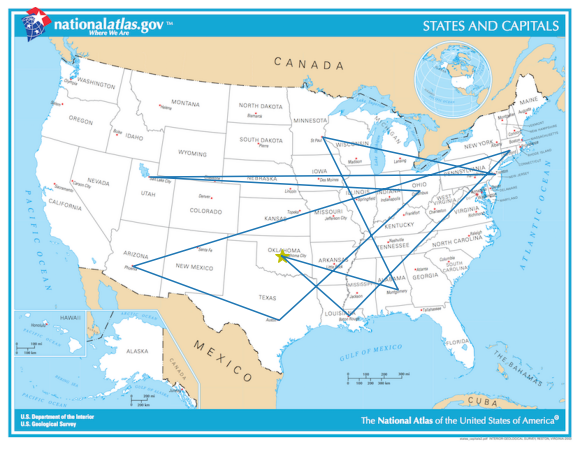

In [63]:
# Crio uma instancia do problema e ploto
num_cidades = 10
capitais_tsp = TravelingSalesman(capitais_list[:num_cidades])
cidade_inicial = capitais_list[0]
print("Valor da rota inicialmente: {:.2f}".format(-capitais_tsp.pega_valor()))
print(capitais_list[:num_cidades])  # ponto de partida e chegada é uma estrela amarela
mostra_caminho(capitais_tsp.coords, cidade_inicial)

In [64]:
import time

Tempo de execucao é  1.1970338821411133
Comprimento da rota encontrada é: 2005.27
[('Saint Paul', [451.6, 186.0]), ('Hartford', [719.6, 205.2]), ('Columbus', [590.8, 263.2]), ('Austin', [389.2, 448.4]), ('Baton Rouge', [489.6, 442.0]), ('Montgomery', [559.6, 404.8]), ('Trenton', [698.8, 239.6]), ('Oklahoma City', [392.8, 356.4]), ('Phoenix', [179.6, 371.2]), ('Salt Lake City', [204.0, 243.2])]


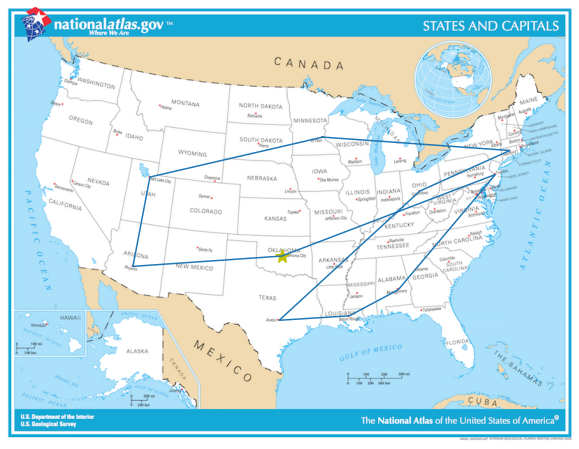

In [70]:
alpha = 0.95
temperatura=1e8
t0 = time.time()
resultado = sa(capitais_tsp, esquema)
t1 = time.time() - t0
print ("Tempo de execucao é ", t1)
print("Comprimento da rota encontrada é: {:.2f}".format(-resultado.pega_valor()))
print(resultado.caminho)
mostra_caminho(resultado.coords, cidade_inicial)

### Experimentos

#### 1. Execute o agente repetidamente

- n = 10, alpha = 0.95, temperatura=1e6
- tamanho da rota inicial: 3074.15
- tamanho da rota final (médio): 
- Rode o experimento  N = 100 vezes para obter uma distribuição dos comprimentos de rota encontrados
- Plote um histograma mostrando a distribuição dos comprimentos de rota 

#### 2. Altere o numero de cidades, use 10, 20 e 30. Como o algoritmo se comporta ?

- n = 10
    - tempo de execução:
    - comprimento da rota inicial: 
    - comprimento da rota encontrada: 
- n = 20
    - tempo de execução:
    - comprimento da rota inicial: 
    - comprimento da rota encontrada: 
- n = 30
    - tempo de execução:
    - comprimento da rota inicial: 
    - comprimento da rota encontrada: 


#### 3. Altere os parametros  alpha e temperatura .  Como isso afeta os resultados?

- n = 10, rota inicial 3074
- alpha (temperatura 1e6), tempo execucao, rota final : 
    - 0.99, ..., ...
    - 0.97, ..., ... 
    - 0.95, ..., ...
    - 0.90, ..., ...
    - 0.80, ..., ...
    - 0.50, ..., ...
    - 0.10, ..., ...
- temperatura (alpha 0.95), tempo de execucao, rota final: 
    - 1e9,..., ...
    - 1e8,..., ...
    - 1e7,..., ...
    - 1e6, ..., ...
    - 1e5,..., ...
    - 1e4,..., ...
    - 1e3,..., ...


#### 4. Use um outro esquema de temperatura,  algoritmo ainda é efetivo?

In [66]:
def esquema_linear(tempo):
    return temperatura - alpha * tempo 

def esquema_quadratico(tempo):
    return temperatura - alpha * tempo ** 2

Com n = 10, alpha 0.95 , o tempo de execucao, tamanho da rota: 
- temperatura 1e3
    - esquema exponencial: ..., ...
    - esquema linear: ..., ...
    - esquema quadratico : ..., ...
- temperatura 1e5
    - esquema exponencial: ..., ...
    - esquema linear: ..., ...
    - esquema quadratico : ..., ...
- temperature 1e6
    - esquema exponencial: ..., ...
    - esquema linear: ..., ...
    - esquema quadratico : ..., ...
